# Gaze Correction Pipeline

Click-Anchored Correction（クリック参照点ベース補正）を使用して視線データを補正する。

## 概要

**アルゴリズム**:
1. `choice_click`イベント時刻の視線位置と、クリックした選択肢の`choice_bbox`中心座標のずれを参照点として抽出
2. セグメント（問題）ごとに補正パラメータを推定（参照点が不足する場合は前後から補間）
3. 補正を適用してAOIマッチ率を検証

## 期待される改善
- 補正前: 40-60% AOI内率
- 補正後: 75-90% AOI内率

In [1]:
import sys
sys.path.append('../lib')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

import eyegaze as eg

# データディレクトリ
DATA_INPUT = '../../data/input'
DATA_WORKING = '../../data/working'
OUTPUT_BASE = os.path.join(DATA_WORKING, 'corrections')

## 1. 単一参加者でテスト (P001)

In [2]:
# 参加者とフェーズの設定
GROUP = 'B'
PARTICIPANT = 'P019'
PHASE = 'pre'

# 座標データは同じグループのTestから取得（個人データでは欠損がある場合があるため）
COORD_PARTICIPANT = 'Test'

# AOIマッチング許容値（ピクセル）
# 文間スペース12pxを考慮し、重ならない範囲で設定
TOLERANCE = 5.0  # 上下5pxずつ拡大 → 合計10px < 12px

# スケーリング重視モード設定
# - prefer_scaling=True: スケーリングを優先し、オフセットは残差から計算
# - max_offset=20.0: オフセットを±20px以内に制限
# → 右側ボタンで計算したオフセットが左側テキストに不適切に適用される問題を回避

# パス設定（視線データ・ログ・背景画像は個人データを使用）
participant_dir = os.path.join(DATA_INPUT, GROUP, PARTICIPANT, PHASE)
eye_tracking_dirs = glob(os.path.join(participant_dir, 'eye_tracking', '*'))
eye_tracking_dir = eye_tracking_dirs[0] if eye_tracking_dirs else None

event_log_files = glob(os.path.join(participant_dir, 'logs', 'events_*.jsonl'))
event_log_path = event_log_files[0] if event_log_files else None

# 座標データは同じグループのTestから取得
coord_dir = os.path.join(DATA_INPUT, GROUP, COORD_PARTICIPANT, PHASE, 'coordinates')

print(f"Eye tracking dir: {eye_tracking_dir}")
print(f"Event log: {event_log_path}")
print(f"Coordinates dir: {coord_dir} (from {GROUP}/{COORD_PARTICIPANT})")
print(f"Tolerance: {TOLERANCE}px")

Eye tracking dir: ../../data/input/B/P019/pre/eye_tracking/2026-01-08_10-22-58.210352
Event log: ../../data/input/B/P019/pre/logs/events_2026-01-08T01-22-58-350Z.jsonl
Coordinates dir: ../../data/input/B/Test/pre/coordinates (from B/Test)
Tolerance: 5.0px


In [3]:
# 補正パイプラインを実行
output_dir = os.path.join(OUTPUT_BASE, GROUP, PARTICIPANT, PHASE)

result = eg.runClickAnchoredCorrection(
    eye_tracking_dir=eye_tracking_dir,
    event_log_path=event_log_path,
    coord_dir=coord_dir,
    phase=PHASE,
    window_before_ms=200,
    window_after_ms=50,
    min_samples=5,
    outlier_threshold_px=300,
    output_dir=output_dir,
    tolerance=TOLERANCE,
    prefer_scaling=True,     # スケーリング重視モード
    max_offset=20.0,         # オフセット制限（±20px）
    verbose=True
)

Phase: pre
Gaze CSV: ../../data/input/B/P019/pre/eye_tracking/2026-01-08_10-22-58.210352/tobii_pro_gaze.csv
Event log: ../../data/input/B/P019/pre/logs/events_2026-01-08T01-22-58-350Z.jsonl
Coordinates dir: ../../data/input/B/Test/pre/coordinates

Step 1: Extracting click reference points...
  Found 24 reference points
Step 2: Loading segments...
  Found 10 segments
Step 3: Estimating segment corrections...
  Direct: 0, Single point: 2, Interpolated: 1
Step 4: Validating corrections (parallel)...

=== Summary ===
  Segments analyzed: 8
  Reference points: 24
  Original AOI rate: 0.592
  Stage 1 AOI rate: 0.619
  Corrected AOI rate (Stage 2): 0.770
  Improvement: +0.178
  Mean scale: (0.9565, 1.0423)
  Mean offset: (-0.9, -34.1) px

Results saved to: ../../data/working/corrections/B/P019/pre


In [4]:
# 参照点データを確認
ref_points = result['reference_points']
print(f"参照点数: {len(ref_points)}")
ref_points.head(10)

参照点数: 24


,timestamp,segment_id,question_id,choice_id,click_type,expected_x,expected_y,observed_x,observed_y,n_samples,offset_x,offset_y
0,1.767835e+09,pre_01,pre_01_q1,d,choice,1476.5,236.5,1546.630325,283.492472,23,-70.130325,-46.992472
1,1.767835e+09,pre_01,pre_01_q2,c,choice,1341.5,415.5,1343.173199,414.259077,23,-1.673199,1.240923
2,1.767836e+09,pre_02,pre_02_q1,c,choice,1497.5,191.5,1324.565506,235.883524,23,172.934494,-44.383524
3,1.767836e+09,pre_03,pre_03_q1,c,choice,1371.5,191.5,1415.839291,294.633526,23,-44.339291,-103.133526
4,1.767836e+09,pre_03,pre_03_q2,a,choice,1467.5,324.5,1555.280599,353.513407,22,-87.780599,-29.013407
5,1.767836e+09,pre_03,pre_03_q3,c,choice,1413.0,639.5,1357.062550,648.082230,23,55.937450,-8.582230
6,1.767836e+09,pre_03,pre_03_q3,d,choice,1419.0,684.5,1342.950954,710.624333,22,76.049046,-26.124333
7,1.767836e+09,pre_03,pre_03_q3,a,choice,1436.0,548.5,1370.026302,550.392653,23,65.973698,-1.892653
8,1.767836e+09,pre_04,pre_04_q1,b,choice,1448.0,179.5,1310.442524,230.821029,17,137.557476,-51.321029
9,1.767836e+09,pre_06,pre_06_q1,a,choice,1432.0,100.5,1517.117929,182.177708,22,-85.117929,-81.677708


In [5]:
# セグメント補正値を確認
seg_corrections = result['segment_corrections']
print(f"セグメント数: {len(seg_corrections)}")
seg_corrections

セグメント数: 8


,segment_id,segment_index,event_type,scale_x,scale_y,offset_x,offset_y,n_reference_points,method
0,pre_01,1,question_screen_open,0.914897,1.145795,5.364636,4.989208,2,scaling_priority
1,pre_02,2,question_screen_open,1.000000,1.000000,20.000000,-20.000000,1,single_point
2,pre_03,3,question_screen_open,1.005721,1.186272,10.603656,-20.000000,5,scaling_priority
3,pre_04,4,question_screen_open,1.000000,1.000000,20.000000,-20.000000,1,single_point
4,pre_05,5,question_screen_open,0.966513,1.099713,16.311530,-20.000000,0,interpolated
5,pre_06,6,question_screen_open,0.933027,1.199426,12.623059,-20.000000,4,scaling_priority
6,pre_07,7,question_screen_open,0.942729,1.067319,-20.000000,-20.000000,3,scaling_priority
7,pre_08,8,question_screen_open,0.940752,0.878845,20.000000,-6.444305,8,scaling_priority


In [6]:
# 検証結果を確認
validation = pd.DataFrame(result['validation_results'])
print(f"検証セグメント数: {len(validation)}")
validation

検証セグメント数: 8


,segment_id,segment_index,original_rate,stage1_rate,corrected_rate,improvement,n_fixations,scale_x,scale_y,offset_x,offset_y,s2_scale_x,s2_scale_y,s2_offset_x,s2_offset_y,method
0,pre_01,1,0.576531,0.571429,0.693878,0.117347,196,0.969791,1.054132,-4.313486,-25.409928,1.06,0.92,-10.0,-30.0,scaling_priority
1,pre_02,2,0.633700,0.600733,0.820513,0.186813,273,1.000000,1.000000,0.000000,-50.000000,1.00,1.00,-20.0,-30.0,single_point
2,pre_03,3,0.493590,0.705128,0.846154,0.352564,312,0.945378,1.091370,-10.032563,-28.400000,0.94,0.92,-20.0,-10.0,scaling_priority
3,pre_04,4,0.591716,0.621302,0.751479,0.159763,169,0.900000,1.040000,13.000000,-25.800000,0.90,1.04,-5.0,-5.0,single_point
4,pre_05,5,0.652174,0.554348,0.722826,0.070652,184,0.889192,1.011736,5.006607,-8.400000,0.92,0.92,-10.0,10.0,interpolated
5,pre_06,6,0.546703,0.590659,0.793956,0.247253,364,0.970348,1.079483,-1.872018,-48.000000,1.04,0.90,-15.0,-30.0,scaling_priority
6,pre_07,7,0.516355,0.600467,0.728972,0.212617,428,0.961584,1.024626,-10.400000,-49.200000,1.02,0.96,10.0,-30.0,scaling_priority
7,pre_08,8,0.722449,0.708163,0.800000,0.077551,490,1.016013,1.037037,1.600000,-37.604279,1.08,1.18,-20.0,-30.0,scaling_priority


## 2. 補正効果の可視化

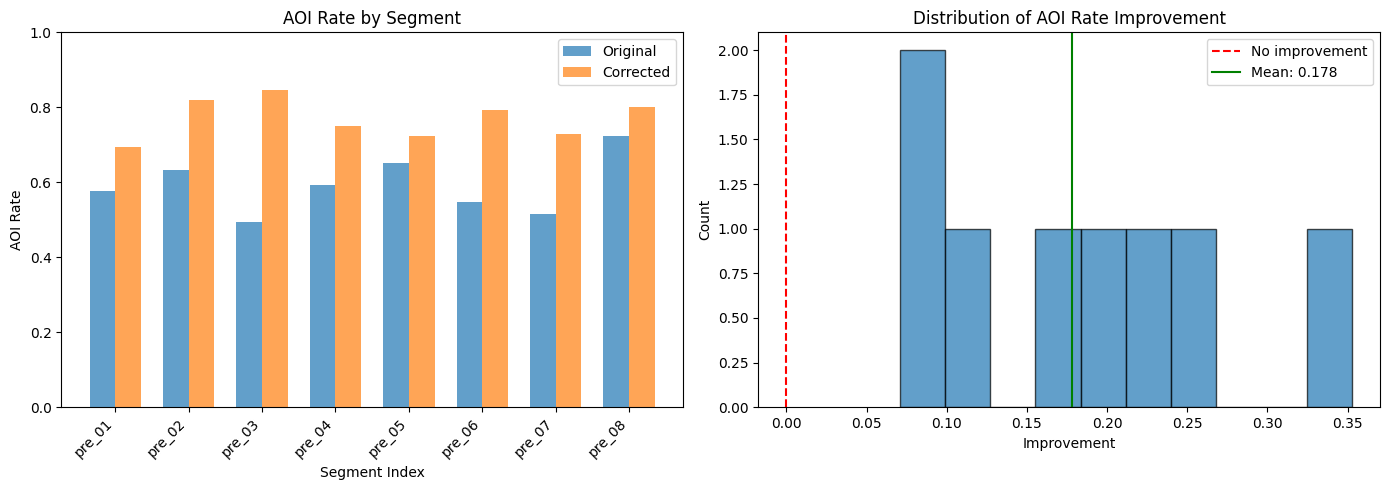

In [7]:
# 補正前後のAOI内率を比較
if len(validation) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # 棒グラフ: セグメントごとのAOI内率
    x = np.arange(len(validation))
    width = 0.35
    
    axes[0].bar(x - width/2, validation['original_rate'], width, label='Original', alpha=0.7)
    axes[0].bar(x + width/2, validation['corrected_rate'], width, label='Corrected', alpha=0.7)
    axes[0].set_xlabel('Segment Index')
    axes[0].set_ylabel('AOI Rate')
    axes[0].set_title('AOI Rate by Segment')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(validation['segment_id'], rotation=45, ha='right')
    axes[0].legend()
    axes[0].set_ylim(0, 1)
    
    # 改善率のヒストグラム
    axes[1].hist(validation['improvement'], bins=10, edgecolor='black', alpha=0.7)
    axes[1].axvline(x=0, color='red', linestyle='--', label='No improvement')
    axes[1].axvline(x=validation['improvement'].mean(), color='green', linestyle='-', label=f'Mean: {validation["improvement"].mean():.3f}')
    axes[1].set_xlabel('Improvement')
    axes[1].set_ylabel('Count')
    axes[1].set_title('Distribution of AOI Rate Improvement')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
else:
    print("No validation results to visualize.")

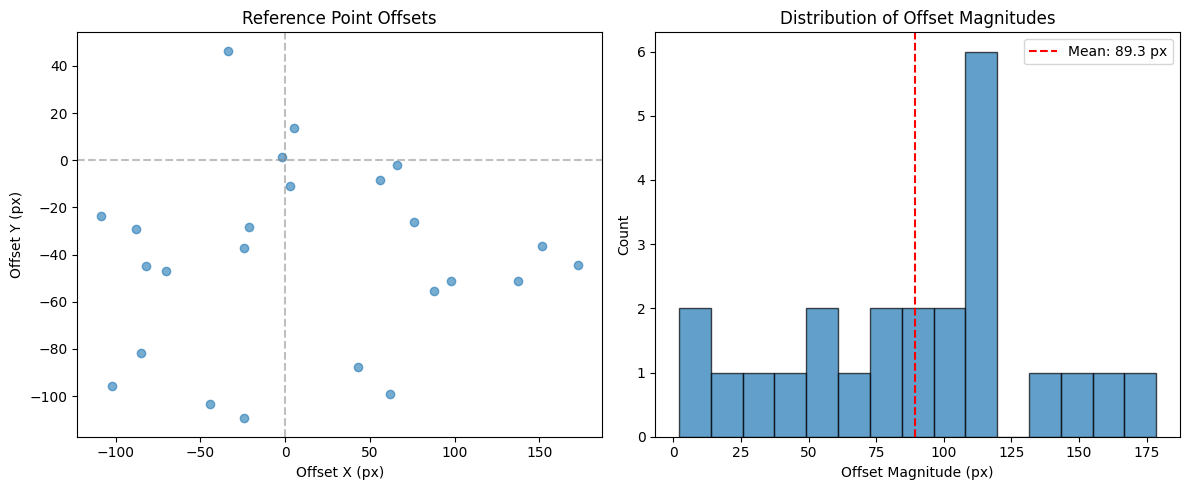

In [8]:
# オフセット分布の可視化
if len(ref_points) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # オフセットの散布図
    axes[0].scatter(ref_points['offset_x'], ref_points['offset_y'], alpha=0.6)
    axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    axes[0].axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    axes[0].set_xlabel('Offset X (px)')
    axes[0].set_ylabel('Offset Y (px)')
    axes[0].set_title('Reference Point Offsets')
    
    # オフセットのヒストグラム
    offset_mag = np.sqrt(ref_points['offset_x']**2 + ref_points['offset_y']**2)
    axes[1].hist(offset_mag, bins=15, edgecolor='black', alpha=0.7)
    axes[1].axvline(x=offset_mag.mean(), color='red', linestyle='--', label=f'Mean: {offset_mag.mean():.1f} px')
    axes[1].set_xlabel('Offset Magnitude (px)')
    axes[1].set_ylabel('Count')
    axes[1].set_title('Distribution of Offset Magnitudes')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
else:
    print("No reference points to visualize.")

## 3. 特定セグメントの補正前後比較

In [9]:
# AOI Rate計算に使用するレベル（画面上の全要素を対象）
# paragraph/wordはsentenceと重複するため除外
AOI_LEVELS = [
    'instruction',   # 問題指示文
    'sentence',      # 本文（文単位）
    'question',      # 問題文
    'choice',        # 選択肢
    'timer',         # タイマー
    'ui',            # UIボタン等
    'header',        # ヘッダー
    'reflection',    # リフレクション入力欄
    'title',         # パッセージタイトル
    'subtitle',      # サブタイトル
    'intro',         # イントロ
    'analog',        # 類題関連
    'metadata',      # メタデータ（送信者、日付等）
    'table',         # 表
    'explanation',   # 解説
    'metacog'        # メタ認知支援解説
]

# 固視点の表示サイズ（固定値）
FIXATION_SIZE = 50

# 特定のセグメントを可視化
def visualize_correction(segment_id, eye_tracking_dir, event_log_path, coord_dir,
                         segment_corrections, phase='pre', tolerance=0.0,
                         scale_x=None, scale_y=None, offset_x=None, offset_y=None):
    """セグメントの補正前後を可視化

    Parameters:
    -----------
    segment_id : str
        対象セグメントID
    eye_tracking_dir : str
        視線データディレクトリ
    event_log_path : str
        イベントログファイルパス
    coord_dir : str
        座標定義ディレクトリ
    segment_corrections : pd.DataFrame
        セグメント補正パラメータ（segment_id, scale_x, scale_y, offset_x, offset_y）
    phase : str
        実験フェーズ
    tolerance : float
        AOI境界からの許容距離（ピクセル）
    scale_x, scale_y : float, optional
        明示的なスケーリング値（指定時はsegment_correctionsより優先）
    offset_x, offset_y : float, optional
        明示的なオフセット値（指定時はsegment_correctionsより優先）
    """
    # セグメントを読み込み
    segments = eg.readTobiiData(eye_tracking_dir, event_log_path, phase=phase)
    seg = [s for s in segments if s.get('passage_id') == segment_id]
    if not seg:
        print(f"Segment {segment_id} not found")
        return
    seg = seg[0]

    data = seg['data']
    image_path = seg.get('image_path', '')

    # AOIを読み込み
    coord_files = [f for f in os.listdir(coord_dir) if f.startswith(f'question_{segment_id}')]
    if not coord_files:
        print(f"Coordinates for {segment_id} not found")
        return
    coord_path = os.path.join(coord_dir, coord_files[0])
    coordinates = eg.loadCoordinates(coord_path)
    
    # 画像ファイル名からAOI抽出パラメータを取得
    aoi_params = {}
    if image_path:
        parsed = eg.parseImageFilename(image_path)
        if parsed:
            aoi_params = {
                'target_locale': parsed['target_locale'],
                'target_question': parsed['target_question'],
                'target_analog': parsed['target_analog'],
            }
    
    aois = eg.extractAllAOIs(coordinates, levels=AOI_LEVELS, **aoi_params)

    # Fixationを検出
    times, X, Y, P = data[:, 0], data[:, 1], data[:, 2], data[:, 3]
    fixations = eg.detectFixations(times, X, Y, P)

    if len(fixations) == 0:
        print("No fixations detected")
        return

    # 補正パラメータを取得（明示的引数があればそれを優先）
    if scale_x is None or scale_y is None or offset_x is None or offset_y is None:
        correction = segment_corrections[segment_corrections['segment_id'] == segment_id]
        if correction.empty:
            sx, sy = 1.0, 1.0
            ox, oy = 0.0, 0.0
        else:
            sx = correction['scale_x'].iloc[0] if 'scale_x' in correction.columns else 1.0
            sy = correction['scale_y'].iloc[0] if 'scale_y' in correction.columns else 1.0
            ox = correction['offset_x'].iloc[0] or 0
            oy = correction['offset_y'].iloc[0] or 0
        # 明示的引数で上書き
        scale_x = scale_x if scale_x is not None else sx
        scale_y = scale_y if scale_y is not None else sy
        offset_x = offset_x if offset_x is not None else ox
        offset_y = offset_y if offset_y is not None else oy

    # 補正を適用
    corrected_fixations = eg.applyScalingAndOffset(fixations, scale_x, scale_y, offset_x, offset_y)

    # 可視化
    fig, axes = plt.subplots(1, 2, figsize=(20, 9))

    for ax, fix_data, title in [(axes[0], fixations, 'Original'),
                                 (axes[1], corrected_fixations, 'Corrected')]:
        # 背景画像
        if os.path.exists(image_path):
            img = plt.imread(image_path)
            ax.imshow(img)

        # AOI領域を描画
        import matplotlib.patches as patches
        for aoi in aois:
            if aoi.get('is_multiline') and 'bboxes' in aoi:
                for bbox in aoi['bboxes']:
                    # tolerance > 0 の場合、拡大領域を薄い色で表示
                    if tolerance > 0:
                        expanded_rect = patches.Rectangle(
                            (bbox['x'] - tolerance, bbox['y'] - tolerance),
                            bbox['width'] + 2 * tolerance,
                            bbox['height'] + 2 * tolerance,
                            linewidth=1, edgecolor='lightgreen', facecolor='lightgreen', alpha=0.2
                        )
                        ax.add_patch(expanded_rect)
                    # 元の枠
                    rect = patches.Rectangle(
                        (bbox['x'], bbox['y']), bbox['width'], bbox['height'],
                        linewidth=1, edgecolor='green', facecolor='none', alpha=0.5
                    )
                    ax.add_patch(rect)
            else:
                bbox = aoi['bbox']
                # tolerance > 0 の場合、拡大領域を薄い色で表示
                if tolerance > 0:
                    expanded_rect = patches.Rectangle(
                        (bbox['x'] - tolerance, bbox['y'] - tolerance),
                        bbox['width'] + 2 * tolerance,
                        bbox['height'] + 2 * tolerance,
                        linewidth=1, edgecolor='lightgreen', facecolor='lightgreen', alpha=0.2
                    )
                    ax.add_patch(expanded_rect)
                # 元の枠
                rect = patches.Rectangle(
                    (bbox['x'], bbox['y']), bbox['width'], bbox['height'],
                    linewidth=1, edgecolor='green', facecolor='none', alpha=0.5
                )
                ax.add_patch(rect)

        # Fixationを描画（固定サイズ）
        fx, fy = fix_data[:, 1], fix_data[:, 2]
        ax.scatter(fx, fy, s=FIXATION_SIZE, c='red', alpha=0.6, edgecolors='darkred', linewidths=0.5)

        # AOI内率を計算（tolerance適用）
        rate_info = eg.computeAllAOIRate(fix_data, aois, tolerance=tolerance)

        ax.set_xlim(0, 1920)
        ax.set_ylim(1080, 0)
        ax.set_title(f'{title} - AOI Rate: {rate_info["rate"]:.3f} ({rate_info["fixations_in_aoi"]}/{rate_info["total_fixations"]})')
        ax.axis('off')

    plt.suptitle(f'Segment: {segment_id} | Scale: ({scale_x:.3f}, {scale_y:.3f}) | Offset: ({offset_x:.1f}, {offset_y:.1f}) px | Tolerance: {tolerance}px', fontsize=14)
    plt.tight_layout()
    plt.show()

    print(f"Scale applied: ({scale_x:.3f}, {scale_y:.3f})")
    print(f"Offset applied: ({offset_x:.1f}, {offset_y:.1f}) px")
    print(f"Tolerance: {tolerance}px")

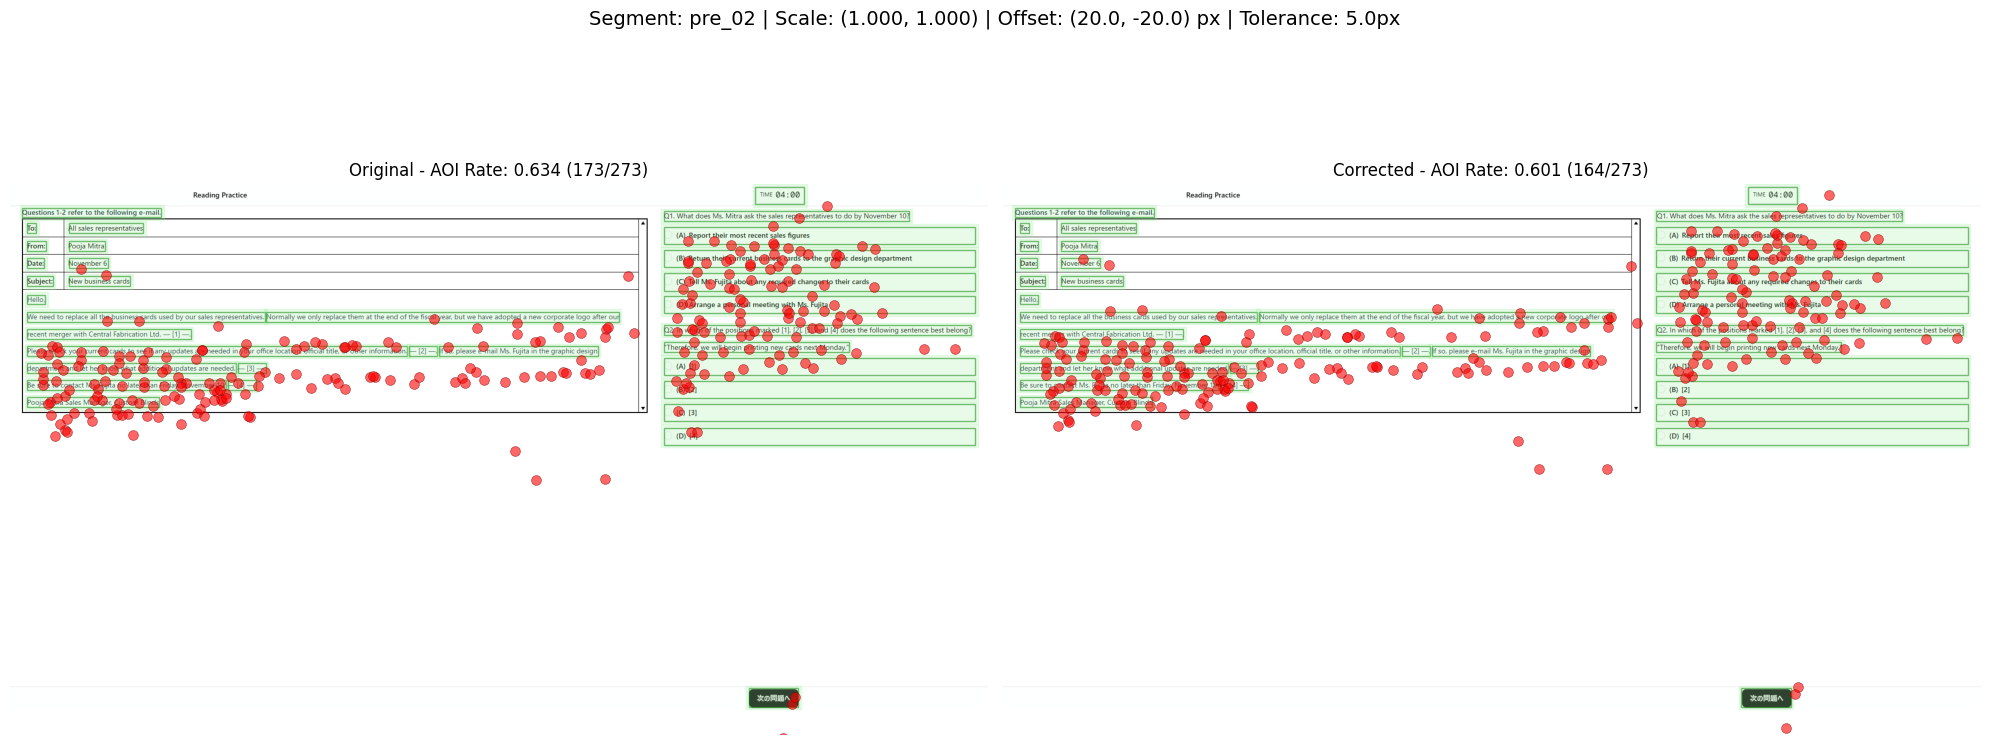

Scale applied: (1.000, 1.000)
Offset applied: (20.0, -20.0) px
Tolerance: 5.0px


In [10]:
# 最初のセグメントを可視化
if len(validation) > 0:
    first_segment = validation.iloc[1]['segment_id']
    visualize_correction(
        first_segment, 
        eye_tracking_dir, 
        event_log_path, 
        coord_dir,
        seg_corrections,
        phase=PHASE,
        tolerance=TOLERANCE
    )

## 3.5 2段階補正アルゴリズム

クリック参照点が右側パネル（選択肢・ボタン）に偏っている問題を解決するため、2段階補正を実装する。

### アプローチ
1. **第1段階（Click-Anchored）**: 既存のクリック参照点ベース補正で大まかなパラメータを推定
2. **第2段階（AOI Rate最適化）**: 第1段階の結果を初期値として、AOI Rate最大化でグリッドサーチにより微調整

### パラメータ探索範囲（第2段階）
- X方向オフセット: ±20px（狭い範囲で微調整）
- Y方向オフセット: ±30px
- Y軸スケーリング: 0.90〜1.30（拡大を許容）

In [11]:
def two_stage_correction(segment_id, eye_tracking_dir, event_log_path, coord_dir,
                         stage1_corrections, phase='pre', tolerance=0.0,
                         stage2_search_x=(-20, 20), stage2_search_y=(-30, 30),
                         stage2_scale_range=(0.90, 1.30),
                         offset_step=5, scale_step=0.02,
                         verbose=True):
    """
    2段階補正を実行

    Parameters:
    -----------
    segment_id : str
        対象セグメントID
    eye_tracking_dir : str
        視線データディレクトリ
    event_log_path : str
        イベントログファイルパス
    coord_dir : str
        座標定義ディレクトリ
    stage1_corrections : pd.DataFrame
        第1段階の補正パラメータ（runClickAnchoredCorrectionの結果）
    phase : str
        実験フェーズ
    tolerance : float
        AOI境界からの許容距離（ピクセル）
    stage2_search_x, stage2_search_y : tuple
        第2段階のオフセット探索範囲
    stage2_scale_range : tuple
        第2段階のスケーリング探索範囲（Y軸）
    offset_step : int
        オフセットの探索刻み幅
    scale_step : float
        スケーリングの探索刻み幅
    verbose : bool
        詳細出力

    Returns:
    --------
    dict
        {
            "segment_id": str,
            "original_fixations": np.ndarray,
            "stage1_fixations": np.ndarray,
            "stage2_fixations": np.ndarray,
            "stage1_params": dict,
            "stage2_params": dict,
            "final_params": dict,
            "original_rate": float,
            "stage1_rate": float,
            "stage2_rate": float,
            "aois": list,
            "image_path": str
        }
    """
    # セグメントを読み込み
    segments = eg.readTobiiData(eye_tracking_dir, event_log_path, phase=phase)
    seg = [s for s in segments if s.get('passage_id') == segment_id]
    if not seg:
        print(f"Segment {segment_id} not found")
        return None
    seg = seg[0]

    data = seg['data']
    image_path = seg.get('image_path', '')

    # AOIを読み込み
    coord_files = [f for f in os.listdir(coord_dir) if f.startswith(f'question_{segment_id}')]
    if not coord_files:
        print(f"Coordinates for {segment_id} not found")
        return None
    coord_path = os.path.join(coord_dir, coord_files[0])
    coordinates = eg.loadCoordinates(coord_path)
    
    # 画像ファイル名からAOI抽出パラメータを取得
    aoi_params = {}
    if image_path:
        parsed = eg.parseImageFilename(image_path)
        if parsed:
            aoi_params = {
                'target_locale': parsed['target_locale'],
                'target_question': parsed['target_question'],
                'target_analog': parsed['target_analog'],
            }
    
    aois = eg.extractAllAOIs(coordinates, levels=AOI_LEVELS, **aoi_params)

    # Fixationを検出
    times, X, Y, P = data[:, 0], data[:, 1], data[:, 2], data[:, 3]
    fixations = eg.detectFixations(times, X, Y, P)

    if len(fixations) == 0:
        print("No fixations detected")
        return None

    # オリジナルのAOI Rate
    original_rate_info = eg.computeAllAOIRate(fixations, aois, tolerance=tolerance)
    original_rate = original_rate_info['rate']

    # --- 第1段階: Click-Anchored補正パラメータを取得 ---
    correction = stage1_corrections[stage1_corrections['segment_id'] == segment_id]
    if correction.empty:
        s1_scale_x, s1_scale_y = 1.0, 1.0
        s1_offset_x, s1_offset_y = 0.0, 0.0
    else:
        s1_scale_x = correction['scale_x'].iloc[0] if 'scale_x' in correction.columns else 1.0
        s1_scale_y = correction['scale_y'].iloc[0] if 'scale_y' in correction.columns else 1.0
        s1_offset_x = correction['offset_x'].iloc[0] or 0
        s1_offset_y = correction['offset_y'].iloc[0] or 0

    # 第1段階の補正を適用
    stage1_fixations = eg.applyScalingAndOffset(
        fixations, s1_scale_x, s1_scale_y, s1_offset_x, s1_offset_y
    )
    stage1_rate_info = eg.computeAllAOIRate(stage1_fixations, aois, tolerance=tolerance)
    stage1_rate = stage1_rate_info['rate']

    if verbose:
        print(f"=== {segment_id} ===")
        print(f"Stage 1 (Click-Anchored):")
        print(f"  Scale: ({s1_scale_x:.3f}, {s1_scale_y:.3f})")
        print(f"  Offset: ({s1_offset_x:.1f}, {s1_offset_y:.1f}) px")
        print(f"  AOI Rate: {original_rate:.3f} -> {stage1_rate:.3f} ({stage1_rate - original_rate:+.3f})")

    # --- 第2段階: AOI Rate最適化による微調整 ---
    # 第1段階補正後のデータに対してグリッドサーチ
    stage2_result = eg.estimateOffsetWithScaling(
        stage1_fixations, aois,
        search_range_x=stage2_search_x,
        search_range_y=stage2_search_y,
        scale_range=stage2_scale_range,
        offset_step=offset_step,
        scale_step=scale_step,
        tolerance=tolerance,
        verbose=False
    )

    s2_scale_x = stage2_result['best_scale_x']
    s2_scale_y = stage2_result['best_scale_y']
    s2_offset_x = stage2_result['best_offset_x']
    s2_offset_y = stage2_result['best_offset_y']

    # 第2段階の補正を適用（第1段階の結果に対して）
    stage2_fixations = eg.applyScalingAndOffset(
        stage1_fixations, s2_scale_x, s2_scale_y, s2_offset_x, s2_offset_y
    )
    stage2_rate_info = eg.computeAllAOIRate(stage2_fixations, aois, tolerance=tolerance)
    stage2_rate = stage2_rate_info['rate']

    if verbose:
        print(f"Stage 2 (AOI Rate Optimization):")
        print(f"  Scale: ({s2_scale_x:.3f}, {s2_scale_y:.3f})")
        print(f"  Offset: ({s2_offset_x:.1f}, {s2_offset_y:.1f}) px")
        print(f"  AOI Rate: {stage1_rate:.3f} -> {stage2_rate:.3f} ({stage2_rate - stage1_rate:+.3f})")

    # 最終パラメータを計算（2段階の合成）
    # 変換式: x' = s2_scale_x * (s1_scale_x * (x - cx) + cx + s1_offset_x - cx) + cx + s2_offset_x
    # 簡略化: final_scale = s1 * s2, final_offset = s2_scale * s1_offset + s2_offset
    final_scale_x = s1_scale_x * s2_scale_x
    final_scale_y = s1_scale_y * s2_scale_y
    final_offset_x = s2_scale_x * s1_offset_x + s2_offset_x
    final_offset_y = s2_scale_y * s1_offset_y + s2_offset_y

    if verbose:
        print(f"Final (Combined):")
        print(f"  Scale: ({final_scale_x:.3f}, {final_scale_y:.3f})")
        print(f"  Offset: ({final_offset_x:.1f}, {final_offset_y:.1f}) px")
        print(f"  Total Improvement: {original_rate:.3f} -> {stage2_rate:.3f} ({stage2_rate - original_rate:+.3f})")

    return {
        "segment_id": segment_id,
        "original_fixations": fixations,
        "stage1_fixations": stage1_fixations,
        "stage2_fixations": stage2_fixations,
        "stage1_params": {
            "scale_x": s1_scale_x, "scale_y": s1_scale_y,
            "offset_x": s1_offset_x, "offset_y": s1_offset_y
        },
        "stage2_params": {
            "scale_x": s2_scale_x, "scale_y": s2_scale_y,
            "offset_x": s2_offset_x, "offset_y": s2_offset_y
        },
        "final_params": {
            "scale_x": final_scale_x, "scale_y": final_scale_y,
            "offset_x": final_offset_x, "offset_y": final_offset_y
        },
        "original_rate": original_rate,
        "stage1_rate": stage1_rate,
        "stage2_rate": stage2_rate,
        "aois": aois,
        "image_path": image_path
    }

In [12]:
def visualize_two_stage(result, tolerance=0.0, save_path=None, show=True):
    """
    2段階補正の結果を3パネルで可視化

    Parameters:
    -----------
    result : dict
        two_stage_correctionの返り値
    tolerance : float
        AOI境界からの許容距離（ピクセル）
    save_path : str, optional
        画像保存先パス（指定時は保存）
    show : bool
        Trueの場合plt.show()で表示（バッチ処理時はFalseに）
    """
    import matplotlib.patches as patches

    if result is None:
        print("No result to visualize")
        return

    fig, axes = plt.subplots(1, 3, figsize=(27, 9))

    data_list = [
        (result['original_fixations'], 'Original', result['original_rate']),
        (result['stage1_fixations'], 'Stage 1 (Click-Anchored)', result['stage1_rate']),
        (result['stage2_fixations'], 'Stage 2 (AOI Optimized)', result['stage2_rate'])
    ]

    aois = result['aois']
    image_path = result['image_path']

    for ax, (fix_data, title, rate) in zip(axes, data_list):
        # 背景画像
        if os.path.exists(image_path):
            img = plt.imread(image_path)
            ax.imshow(img)

        # AOI領域を描画
        for aoi in aois:
            if aoi.get('is_multiline') and 'bboxes' in aoi:
                for bbox in aoi['bboxes']:
                    if tolerance > 0:
                        expanded_rect = patches.Rectangle(
                            (bbox['x'] - tolerance, bbox['y'] - tolerance),
                            bbox['width'] + 2 * tolerance,
                            bbox['height'] + 2 * tolerance,
                            linewidth=1, edgecolor='lightgreen', facecolor='lightgreen', alpha=0.2
                        )
                        ax.add_patch(expanded_rect)
                    rect = patches.Rectangle(
                        (bbox['x'], bbox['y']), bbox['width'], bbox['height'],
                        linewidth=1, edgecolor='green', facecolor='none', alpha=0.5
                    )
                    ax.add_patch(rect)
            else:
                bbox = aoi['bbox']
                if tolerance > 0:
                    expanded_rect = patches.Rectangle(
                        (bbox['x'] - tolerance, bbox['y'] - tolerance),
                        bbox['width'] + 2 * tolerance,
                        bbox['height'] + 2 * tolerance,
                        linewidth=1, edgecolor='lightgreen', facecolor='lightgreen', alpha=0.2
                    )
                    ax.add_patch(expanded_rect)
                rect = patches.Rectangle(
                    (bbox['x'], bbox['y']), bbox['width'], bbox['height'],
                    linewidth=1, edgecolor='green', facecolor='none', alpha=0.5
                )
                ax.add_patch(rect)

        # Fixationを描画（固定サイズ）
        fx, fy = fix_data[:, 1], fix_data[:, 2]
        ax.scatter(fx, fy, s=FIXATION_SIZE, c='red', alpha=0.6, edgecolors='darkred', linewidths=0.5)

        ax.set_xlim(0, 1920)
        ax.set_ylim(1080, 0)
        n_fix = len(fix_data)
        n_in_aoi = int(rate * n_fix)
        ax.set_title(f'{title}\nAOI Rate: {rate:.3f} ({n_in_aoi}/{n_fix})', fontsize=12)
        ax.axis('off')

    # 全体タイトル
    s1 = result['stage1_params']
    s2 = result['stage2_params']
    final = result['final_params']
    plt.suptitle(
        f"Segment: {result['segment_id']} | Tolerance: {tolerance}px\n"
        f"Stage1: scale=({s1['scale_x']:.3f}, {s1['scale_y']:.3f}), offset=({s1['offset_x']:.1f}, {s1['offset_y']:.1f})\n"
        f"Stage2: scale=({s2['scale_x']:.3f}, {s2['scale_y']:.3f}), offset=({s2['offset_x']:.1f}, {s2['offset_y']:.1f})\n"
        f"Final: scale=({final['scale_x']:.3f}, {final['scale_y']:.3f}), offset=({final['offset_x']:.1f}, {final['offset_y']:.1f})",
        fontsize=11
    )
    plt.tight_layout()
    
    # 保存
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        fig.savefig(save_path, dpi=150, bbox_inches='tight')
    
    if show:
        plt.show()
    else:
        plt.close(fig)

    if show:
        # 改善サマリー
        print(f"\n=== Improvement Summary ===")
        print(f"Original -> Stage1: {result['original_rate']:.3f} -> {result['stage1_rate']:.3f} ({result['stage1_rate'] - result['original_rate']:+.3f})")
        print(f"Stage1 -> Stage2: {result['stage1_rate']:.3f} -> {result['stage2_rate']:.3f} ({result['stage2_rate'] - result['stage1_rate']:+.3f})")
        print(f"Total: {result['original_rate']:.3f} -> {result['stage2_rate']:.3f} ({result['stage2_rate'] - result['original_rate']:+.3f})")

In [13]:
# 2段階補正をpre_01セグメントでテスト
test_segment = 'pre_01'
two_stage_result = two_stage_correction(
    segment_id=test_segment,
    eye_tracking_dir=eye_tracking_dir,
    event_log_path=event_log_path,
    coord_dir=coord_dir,
    stage1_corrections=seg_corrections,
    phase=PHASE,
    tolerance=TOLERANCE,
    stage2_search_x=(-20, 20),
    stage2_search_y=(-30, 30),
    stage2_scale_range=(0.90, 1.30),
    offset_step=5,
    scale_step=0.02,
    verbose=True
)

=== pre_01 ===
Stage 1 (Click-Anchored):
  Scale: (0.915, 1.146)
  Offset: (5.4, 5.0) px
  AOI Rate: 0.577 -> 0.571 (-0.005)
Stage 2 (AOI Rate Optimization):
  Scale: (1.060, 0.920)
  Offset: (-10.0, -30.0) px
  AOI Rate: 0.571 -> 0.694 (+0.122)
Final (Combined):
  Scale: (0.970, 1.054)
  Offset: (-4.3, -25.4) px
  Total Improvement: 0.577 -> 0.694 (+0.117)


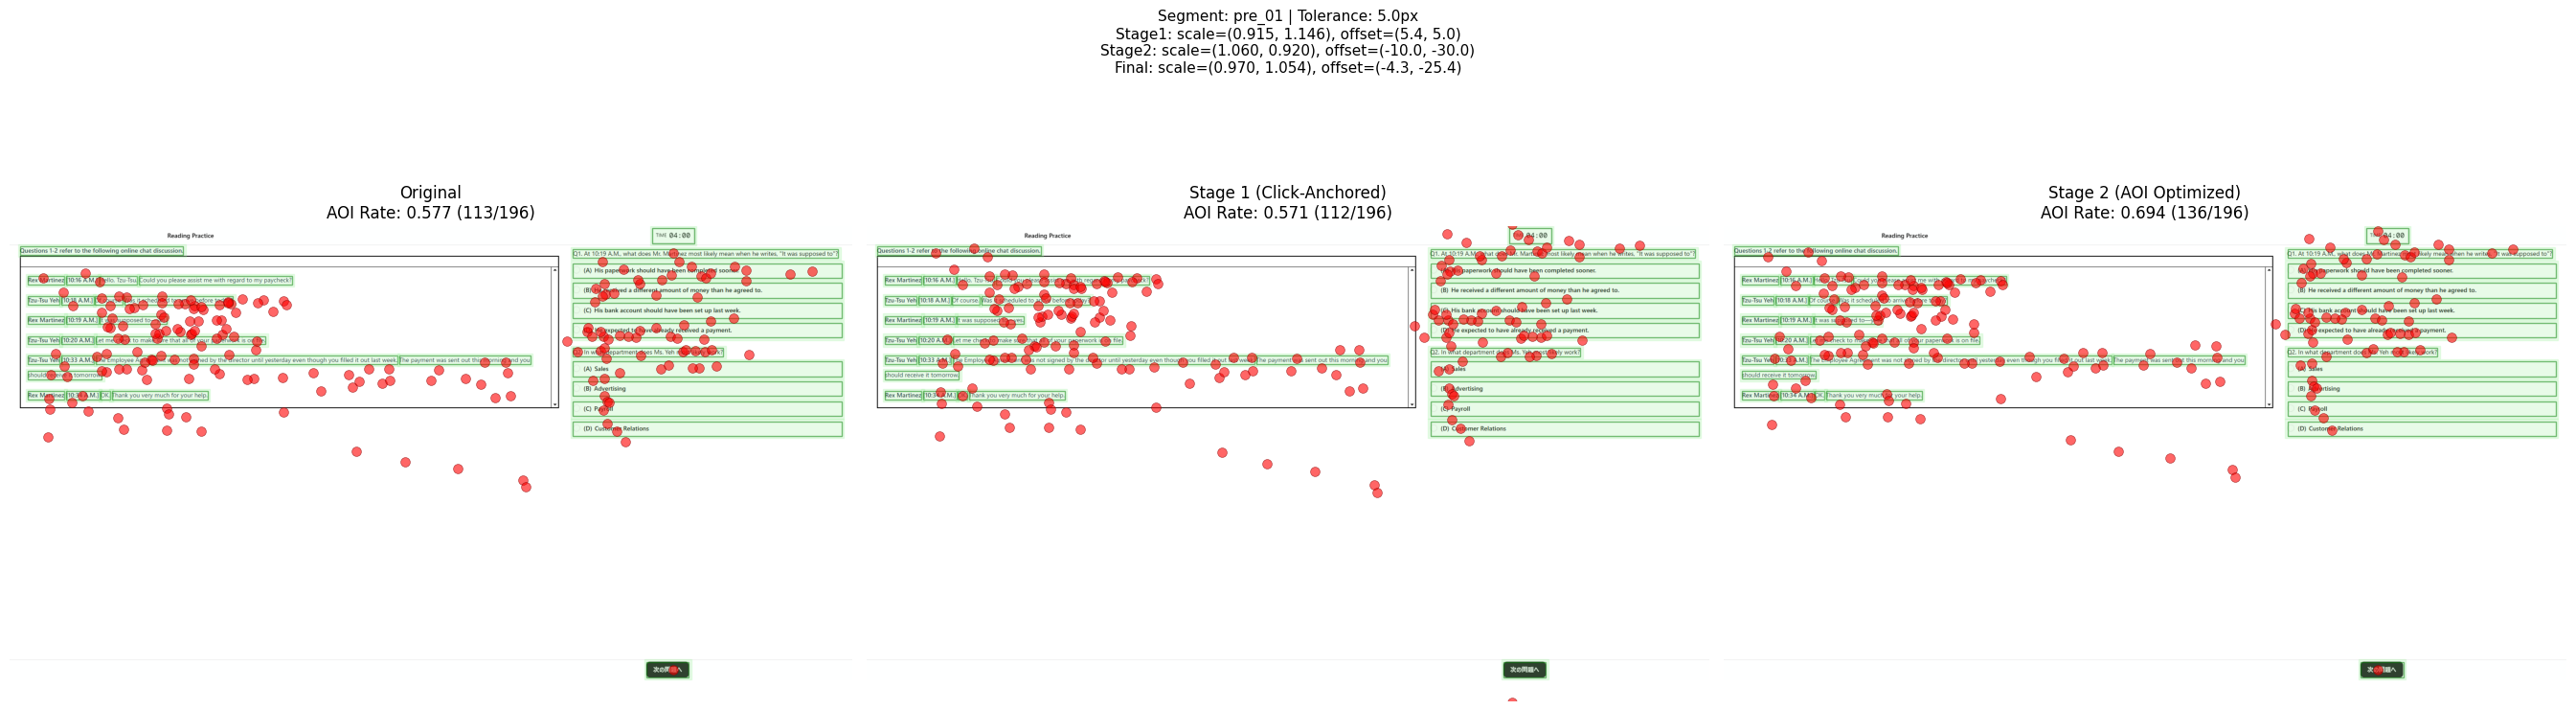


=== Improvement Summary ===
Original -> Stage1: 0.577 -> 0.571 (-0.005)
Stage1 -> Stage2: 0.571 -> 0.694 (+0.122)
Total: 0.577 -> 0.694 (+0.117)


In [14]:
# 3パネルで可視化
if two_stage_result:
    visualize_two_stage(two_stage_result, tolerance=TOLERANCE)

In [15]:
# 全セグメントで2段階補正を実行し、Stage1のみ vs 2段階補正を比較
all_two_stage_results = []

for segment_id in seg_corrections['segment_id']:
    result = two_stage_correction(
        segment_id=segment_id,
        eye_tracking_dir=eye_tracking_dir,
        event_log_path=event_log_path,
        coord_dir=coord_dir,
        stage1_corrections=seg_corrections,
        phase=PHASE,
        tolerance=TOLERANCE,
        stage2_search_x=(-20, 20),
        stage2_search_y=(-30, 30),
        stage2_scale_range=(0.90, 1.30),
        offset_step=5,
        scale_step=0.02,
        verbose=False
    )
    if result:
        all_two_stage_results.append({
            'segment_id': segment_id,
            'original_rate': result['original_rate'],
            'stage1_rate': result['stage1_rate'],
            'stage2_rate': result['stage2_rate'],
            'stage1_improvement': result['stage1_rate'] - result['original_rate'],
            'stage2_improvement': result['stage2_rate'] - result['stage1_rate'],
            'total_improvement': result['stage2_rate'] - result['original_rate'],
            **{f's1_{k}': v for k, v in result['stage1_params'].items()},
            **{f's2_{k}': v for k, v in result['stage2_params'].items()},
            **{f'final_{k}': v for k, v in result['final_params'].items()}
        })

two_stage_df = pd.DataFrame(all_two_stage_results)
print("=== 2段階補正サマリー ===")
print(f"平均Original Rate: {two_stage_df['original_rate'].mean():.3f}")
print(f"平均Stage1 Rate: {two_stage_df['stage1_rate'].mean():.3f} (平均改善: {two_stage_df['stage1_improvement'].mean():+.3f})")
print(f"平均Stage2 Rate: {two_stage_df['stage2_rate'].mean():.3f} (平均改善: {two_stage_df['stage2_improvement'].mean():+.3f})")
print(f"合計改善: {two_stage_df['total_improvement'].mean():+.3f}")
print()
two_stage_df

=== 2段階補正サマリー ===
平均Original Rate: 0.580
平均Stage1 Rate: 0.611 (平均改善: +0.031)
平均Stage2 Rate: 0.756 (平均改善: +0.145)
合計改善: +0.176



,segment_id,original_rate,stage1_rate,stage2_rate,stage1_improvement,stage2_improvement,total_improvement,s1_scale_x,s1_scale_y,s1_offset_x,s1_offset_y,s2_scale_x,s2_scale_y,s2_offset_x,s2_offset_y,final_scale_x,final_scale_y,final_offset_x,final_offset_y
0,pre_01,0.576531,0.571429,0.693878,-0.005102,0.122449,0.117347,0.914897,1.145795,5.364636,4.989208,1.06,0.92,-10.0,-30.0,0.969791,1.054132,-4.313486,-25.409928
1,pre_02,0.633700,0.600733,0.820513,-0.032967,0.219780,0.186813,1.000000,1.000000,20.000000,-20.000000,1.00,1.00,-20.0,-30.0,1.000000,1.000000,0.000000,-50.000000
2,pre_03,0.493590,0.705128,0.846154,0.211538,0.141026,0.352564,1.005721,1.186272,10.603656,-20.000000,0.94,0.92,-20.0,-10.0,0.945378,1.091370,-10.032563,-28.400000
3,pre_04,0.591716,0.621302,0.751479,0.029586,0.130178,0.159763,1.000000,1.000000,20.000000,-20.000000,0.90,1.04,-5.0,-5.0,0.900000,1.040000,13.000000,-25.800000
4,pre_05,0.559783,0.489130,0.614130,-0.070652,0.125000,0.054348,0.966513,1.099713,16.311530,-20.000000,1.06,0.94,-20.0,15.0,1.024504,1.033730,-2.709779,-3.800000
5,pre_06,0.546703,0.590659,0.793956,0.043956,0.203297,0.247253,0.933027,1.199426,12.623059,-20.000000,1.04,0.90,-15.0,-30.0,0.970348,1.079483,-1.872018,-48.000000
6,pre_07,0.516355,0.600467,0.726636,0.084112,0.126168,0.210280,0.942729,1.067319,-20.000000,-20.000000,1.02,0.96,5.0,-30.0,0.961584,1.024626,-15.400000,-49.200000
7,pre_08,0.722449,0.708163,0.800000,-0.014286,0.091837,0.077551,0.940752,0.878845,20.000000,-6.444305,1.08,1.18,-20.0,-30.0,1.016013,1.037037,1.600000,-37.604279


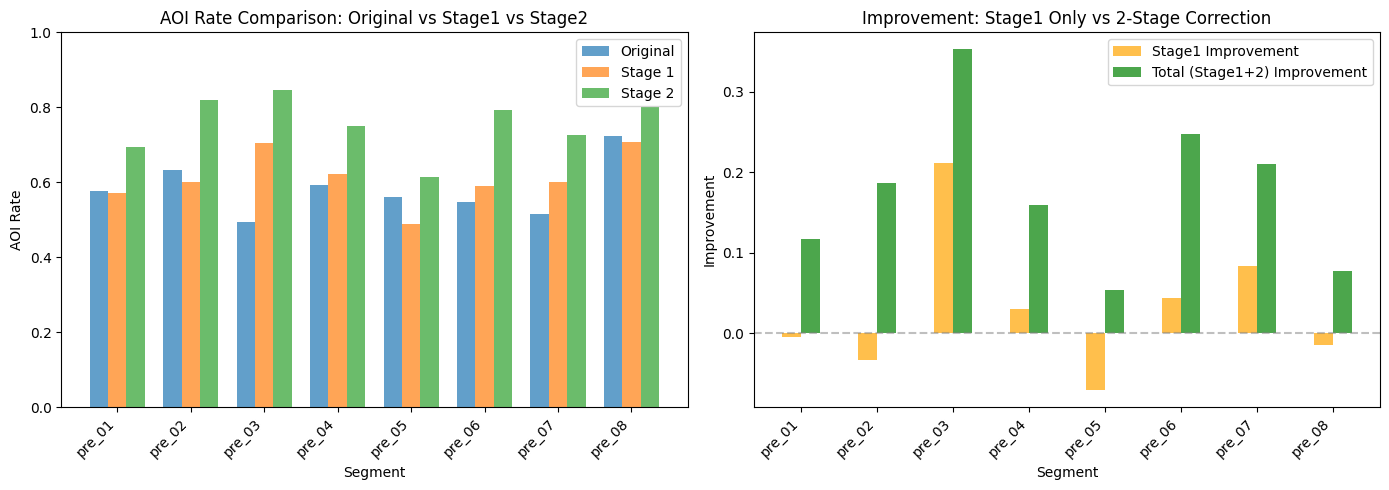


=== Stage1で悪化したセグメント ===
  pre_01: Stage1 -0.005 -> Total +0.117 (改善)
  pre_02: Stage1 -0.033 -> Total +0.187 (改善)
  pre_05: Stage1 -0.071 -> Total +0.054 (改善)
  pre_08: Stage1 -0.014 -> Total +0.078 (改善)


In [16]:
# 2段階補正の効果を可視化
if len(two_stage_df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # 棒グラフ: セグメントごとのAOI Rate比較（Original, Stage1, Stage2）
    x = np.arange(len(two_stage_df))
    width = 0.25

    axes[0].bar(x - width, two_stage_df['original_rate'], width, label='Original', alpha=0.7)
    axes[0].bar(x, two_stage_df['stage1_rate'], width, label='Stage 1', alpha=0.7)
    axes[0].bar(x + width, two_stage_df['stage2_rate'], width, label='Stage 2', alpha=0.7)
    axes[0].set_xlabel('Segment')
    axes[0].set_ylabel('AOI Rate')
    axes[0].set_title('AOI Rate Comparison: Original vs Stage1 vs Stage2')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(two_stage_df['segment_id'], rotation=45, ha='right')
    axes[0].legend()
    axes[0].set_ylim(0, 1)

    # Stage1のみ vs 2段階補正の改善率比較
    axes[1].bar(x - width/2, two_stage_df['stage1_improvement'], width, label='Stage1 Improvement', alpha=0.7, color='orange')
    axes[1].bar(x + width/2, two_stage_df['total_improvement'], width, label='Total (Stage1+2) Improvement', alpha=0.7, color='green')
    axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    axes[1].set_xlabel('Segment')
    axes[1].set_ylabel('Improvement')
    axes[1].set_title('Improvement: Stage1 Only vs 2-Stage Correction')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(two_stage_df['segment_id'], rotation=45, ha='right')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

    # Stage1で悪化したセグメントがStage2で改善されたかを確認
    degraded_in_s1 = two_stage_df[two_stage_df['stage1_improvement'] < 0]
    if len(degraded_in_s1) > 0:
        print("\n=== Stage1で悪化したセグメント ===")
        for _, row in degraded_in_s1.iterrows():
            recovered = "改善" if row['total_improvement'] > row['stage1_improvement'] else "未改善"
            print(f"  {row['segment_id']}: Stage1 {row['stage1_improvement']:+.3f} -> Total {row['total_improvement']:+.3f} ({recovered})")

## 4. 全参加者にバッチ適用

In [17]:
# 全参加者リスト
PARTICIPANTS = {
    'A': ['P001', 'P002', 'P005', 'P006', 'P008', 'P009', 'P010', 'P011', 'P016', 'P017'],
    'B': ['P003', 'P004', 'P007', 'P012', 'P013', 'P014', 'P015', 'P018', 'P019', 'P020']
}

# 全フェーズ
PHASES = ['pre', 'training1', 'training2', 'training3', 'post']

print(f"A群: {len(PARTICIPANTS['A'])}名")
print(f"B群: {len(PARTICIPANTS['B'])}名")
print(f"フェーズ: {PHASES}")

A群: 10名
B群: 10名
フェーズ: ['pre', 'training1', 'training2', 'training3', 'post']


In [18]:
def run_batch_correction(groups, phases, data_input, output_base, 
                         tolerance=5.0, prefer_scaling=True, max_offset=20.0,
                         coord_participant='Test',
                         verbose=False):
    """全参加者・全フェーズに補正を適用
    
    Parameters:
    -----------
    groups : dict
        グループごとの参加者リスト {'A': ['P001', ...], 'B': [...]}
    phases : list
        処理するフェーズのリスト ['pre', 'post', ...]
    data_input : str
        入力データのベースディレクトリ
    output_base : str
        出力先のベースディレクトリ
    tolerance : float
        AOIマッチング許容値（ピクセル）
    prefer_scaling : bool
        スケーリング優先モード
    max_offset : float
        オフセット制限値
    coord_participant : str
        座標データを取得する参加者ID（デフォルト: 'Test'）
    verbose : bool
        詳細出力
    
    Returns:
    --------
    pd.DataFrame
        全参加者・全フェーズの補正結果サマリー
    """
    all_results = []
    all_segment_corrections = []  # 全セグメントの補正パラメータを収集
    
    for group, participants in groups.items():
        for participant in participants:
            for phase in phases:
                print(f"Processing {group}/{participant}/{phase}...")
                
                # パス設定（視線データ・ログは個人データ）
                participant_dir = os.path.join(data_input, group, participant, phase)
                if not os.path.exists(participant_dir):
                    print(f"  Directory not found: {participant_dir}")
                    continue
                
                eye_tracking_dirs = glob(os.path.join(participant_dir, 'eye_tracking', '*'))
                event_log_files = glob(os.path.join(participant_dir, 'logs', 'events_*.jsonl'))
                
                # 座標データは同じグループのTestから取得
                coord_dir = os.path.join(data_input, group, coord_participant, phase, 'coordinates')
                
                if not eye_tracking_dirs or not event_log_files:
                    print(f"  Missing data files")
                    continue
                
                if not os.path.exists(coord_dir):
                    print(f"  Coordinates not found: {coord_dir}")
                    continue
                
                try:
                    output_dir = os.path.join(output_base, group, participant, phase)
                    result = eg.runClickAnchoredCorrection(
                        eye_tracking_dir=eye_tracking_dirs[0],
                        event_log_path=event_log_files[0],
                        coord_dir=coord_dir,
                        phase=phase,
                        output_dir=output_dir,
                        tolerance=tolerance,
                        prefer_scaling=prefer_scaling,
                        max_offset=max_offset,
                        verbose=verbose
                    )
                    
                    # サマリー情報を追加
                    summary = result['summary']
                    summary['group'] = group
                    summary['participant'] = participant
                    summary['phase'] = phase
                    all_results.append(summary)
                    
                    # セグメント補正パラメータを収集
                    seg_corr = result['segment_corrections'].copy()
                    seg_corr['group'] = group
                    seg_corr['participant'] = participant
                    seg_corr['phase'] = phase
                    all_segment_corrections.append(seg_corr)
                    
                    print(f"  Original: {summary['mean_original_rate']:.3f} -> Corrected: {summary['mean_corrected_rate']:.3f} (Improvement: {summary['mean_improvement']:+.3f})")
                    
                except Exception as e:
                    print(f"  Error: {e}")
                    import traceback
                    traceback.print_exc()
                    continue
    
    # 全セグメント補正パラメータを結合
    if all_segment_corrections:
        all_corrections_df = pd.concat(all_segment_corrections, ignore_index=True)
    else:
        all_corrections_df = pd.DataFrame()
    
    return pd.DataFrame(all_results), all_corrections_df

In [19]:
# バッチ実行：全参加者・全フェーズの補正パラメータを取得
print("=== バッチ補正を実行中 ===")
print(f"グループ: {list(PARTICIPANTS.keys())}")
print(f"フェーズ: {PHASES}")
print(f"座標データ: 各グループのTestを使用")
print(f"Tolerance: {TOLERANCE}px")
print()

batch_summary, all_corrections = run_batch_correction(
    PARTICIPANTS, 
    PHASES, 
    DATA_INPUT, 
    OUTPUT_BASE,
    tolerance=TOLERANCE,
    prefer_scaling=True,
    max_offset=20.0,
    coord_participant='Test',
    verbose=False
)

print()
print("=== 処理完了 ===")
print(f"処理した参加者×フェーズ: {len(batch_summary)}件")
print(f"セグメント補正パラメータ: {len(all_corrections)}件")

=== バッチ補正を実行中 ===
グループ: ['A', 'B']
フェーズ: ['pre', 'training1', 'training2', 'training3', 'post']
座標データ: 各グループのTestを使用
Tolerance: 5.0px

Processing A/P001/pre...
  Original: 0.630 -> Corrected: 0.823 (Improvement: +0.193)
Processing A/P001/training1...
  Original: 0.669 -> Corrected: 0.803 (Improvement: +0.134)
Processing A/P001/training2...
  Original: 0.676 -> Corrected: 0.853 (Improvement: +0.177)
Processing A/P001/training3...
  Original: 0.551 -> Corrected: 0.730 (Improvement: +0.180)
Processing A/P001/post...
  Original: 0.681 -> Corrected: 0.829 (Improvement: +0.148)
Processing A/P002/pre...
  Original: 0.668 -> Corrected: 0.753 (Improvement: +0.085)
Processing A/P002/training1...
  Original: 0.690 -> Corrected: 0.772 (Improvement: +0.082)
Processing A/P002/training2...
  Original: 0.683 -> Corrected: 0.776 (Improvement: +0.092)
Processing A/P002/training3...
  Original: 0.596 -> Corrected: 0.733 (Improvement: +0.137)
Processing A/P002/post...
  Original: 0.714 -> Corrected: 0.782

In [20]:
# 結果をCSVに保存
os.makedirs(OUTPUT_BASE, exist_ok=True)

# 1. サマリー（参加者×フェーズごとの平均AOI Rate）
summary_path = os.path.join(OUTPUT_BASE, 'batch_summary.csv')
batch_summary.to_csv(summary_path, index=False)
print(f"サマリー保存: {summary_path}")

# 2. 全セグメントの補正パラメータ
corrections_path = os.path.join(OUTPUT_BASE, 'all_segment_corrections.csv')
all_corrections.to_csv(corrections_path, index=False)
print(f"補正パラメータ保存: {corrections_path}")

print()
print("=== 保存した補正パラメータの列 ===")
print(all_corrections.columns.tolist())
print()
print("=== サンプルデータ（最初の5行） ===")
all_corrections.head()

サマリー保存: ../../data/working/corrections/batch_summary.csv
補正パラメータ保存: ../../data/working/corrections/all_segment_corrections.csv

=== 保存した補正パラメータの列 ===
['segment_id', 'segment_index', 'event_type', 'scale_x', 'scale_y', 'offset_x', 'offset_y', 'n_reference_points', 'method', 'group', 'participant', 'phase']

=== サンプルデータ（最初の5行） ===


,segment_id,segment_index,event_type,scale_x,scale_y,offset_x,offset_y,n_reference_points,method,group,participant,phase
0,pre_01,1,question_screen_open,0.905922,0.973363,4.489135,-6.155906,2,scaling_priority,A,P001,pre
1,pre_02,2,question_screen_open,1.000000,1.000000,20.000000,20.000000,1,single_point,A,P001,pre
2,pre_03,3,question_screen_open,0.962106,0.830280,4.140495,-4.888192,4,scaling_priority,A,P001,pre
3,pre_04,4,question_screen_open,0.888198,0.860321,0.440308,-3.035912,3,scaling_priority,A,P001,pre
4,pre_05,5,question_screen_open,1.000000,1.000000,20.000000,20.000000,1,single_point,A,P001,pre


In [21]:
# バッチ結果のサマリー統計
print("=== グループ×フェーズ別の平均AOI Rate ===")
summary_stats = batch_summary.groupby(['group', 'phase']).agg({
    'mean_original_rate': 'mean',
    'mean_corrected_rate': 'mean',
    'mean_improvement': 'mean'
}).round(3)
print(summary_stats)

print()
print("=== 全体サマリー ===")
print(f"平均Original Rate: {batch_summary['mean_original_rate'].mean():.3f}")
print(f"平均Corrected Rate: {batch_summary['mean_corrected_rate'].mean():.3f}")
print(f"平均改善率: {batch_summary['mean_improvement'].mean():+.3f}")

# 補正パラメータの統計
print()
print("=== 補正パラメータの統計 ===")
param_stats = all_corrections[['scale_x', 'scale_y', 'offset_x', 'offset_y']].describe().round(3)
print(param_stats)

=== グループ×フェーズ別の平均AOI Rate ===
                 mean_original_rate  mean_corrected_rate  mean_improvement
group phase                                                               
A     post                    0.660                0.806             0.146
      pre                     0.656                0.792             0.136
      training1               0.653                0.790             0.137
      training2               0.692                0.819             0.127
      training3               0.569                0.753             0.184
B     post                    0.679                0.786             0.108
      pre                     0.647                0.786             0.138
      training1               0.622                0.745             0.123
      training2               0.664                0.789             0.125
      training3               0.574                0.699             0.124

=== 全体サマリー ===
平均Original Rate: 0.642
平均Corrected Rate: 0.777
平均改善率: 

In [22]:
def save_batch_visualizations_parallel(groups, phases, data_input, output_base, 
                                        all_corrections_df, tolerance=5.0, 
                                        coord_participant='Test',
                                        n_workers=80):
    """
    全参加者・全セグメントの3パネル画像を並列処理で保存
    
    eyegaze.py の process_segment_worker を使用
    セグメントデータと座標パスを事前に読み込み、引数で渡すことで高速化
    """
    from concurrent.futures import ProcessPoolExecutor, as_completed
    from tqdm import tqdm
    
    image_dir = os.path.join(output_base, 'visualizations')
    os.makedirs(image_dir, exist_ok=True)
    
    # 1. 全タスクのリストを作成
    tasks = []
    
    for group, participants in groups.items():
        for participant in participants:
            for phase in phases:
                # パス設定
                participant_dir = os.path.join(data_input, group, participant, phase)
                if not os.path.exists(participant_dir):
                    continue
                
                eye_tracking_dirs = glob(os.path.join(participant_dir, 'eye_tracking', '*'))
                event_log_files = glob(os.path.join(participant_dir, 'logs', 'events_*.jsonl'))
                coord_dir = os.path.join(data_input, group, coord_participant, phase, 'coordinates')
                
                if not eye_tracking_dirs or not event_log_files or not os.path.exists(coord_dir):
                    continue
                
                # この参加者・フェーズの補正パラメータを取得
                participant_corrections = all_corrections_df[
                    (all_corrections_df['group'] == group) &
                    (all_corrections_df['participant'] == participant) &
                    (all_corrections_df['phase'] == phase)
                ]
                
                if participant_corrections.empty:
                    continue
                
                # セグメントを1回だけ読み込み（高速化のポイント1）
                segments = eg.readTobiiData(
                    eye_tracking_dirs[0], event_log_files[0], phase=phase
                )
                
                # 座標マッピングを1回だけ作成（高速化のポイント2）
                coord_mapping = eg.buildCoordinateMapping(coord_dir)
                
                # 各セグメントをタスクとして追加
                for _, row in participant_corrections.iterrows():
                    segment_id = row['segment_id']
                    segment_index = int(row['segment_index'])
                    
                    # segment_indexでセグメントを取得
                    if segment_index >= len(segments):
                        continue
                    seg = segments[segment_index]
                    segment_data = seg['data']
                    image_path = seg.get('image_path', '')
                    
                    # マッピングから座標パスを取得（複合キーを使用）
                    event_type = row.get('event_type', '')
                    prefix = eg._eventTypeToCoordPrefix(event_type)
                    coord_path = coord_mapping.get((prefix, segment_id))
                    # intro/complete画面はseg_id=Noneでマップされているのでフォールバック
                    if not coord_path and prefix in ('training_intro', 'analog_intro', 'training_complete'):
                        coord_path = coord_mapping.get((prefix, None))
                    
                    # segment_idがNoneの場合はevent_typeを使用（intro/complete画面）
                    name_part = segment_id if segment_id else event_type
                    save_path = os.path.join(
                        image_dir, group, participant, phase,
                        f'{segment_index:02d}_{name_part}_correction.png'
                    )
                    
                    # 補正パラメータをdictに変換
                    correction_dict = row.to_dict()
                    
                    # eyegaze.py の process_segment_worker 用の引数タプル
                    # segment_data, image_path, coord_path を直接渡す
                    task_args = (
                        segment_index,
                        segment_id,
                        segment_data,
                        image_path,
                        coord_path,         # 座標パス（マッピングから取得）
                        correction_dict,
                        tolerance,
                        save_path,
                        AOI_LEVELS,
                        FIXATION_SIZE
                    )
                    tasks.append(task_args)
    
    print(f"=== 並列処理を開始 ===")
    print(f"総タスク数: {len(tasks)}")
    print(f"ワーカー数: {n_workers}")
    print()
    
    # 2. 並列実行（eyegaze.pyのワーカー関数を使用）
    success_count = 0
    error_count = 0
    errors = []
    
    with ProcessPoolExecutor(max_workers=n_workers) as executor:
        futures = {executor.submit(eg.process_segment_worker, task): task for task in tasks}
        
        for future in tqdm(as_completed(futures), total=len(futures), desc="Processing segments"):
            result = future.result()
            if result['success']:
                success_count += 1
            else:
                error_count += 1
                errors.append(f"{result['segment_id']}: {result['error']}")
    
    print()
    print(f"=== 完了 ===")
    print(f"保存先: {image_dir}")
    print(f"成功: {success_count}/{len(tasks)}")
    print(f"エラー: {error_count}")
    
    if errors and len(errors) <= 10:
        print("\nエラー詳細:")
        for err in errors[:10]:
            print(f"  - {err[:100]}...")
    elif errors:
        print(f"\n最初の10件のエラー:")
        for err in errors[:10]:
            print(f"  - {err[:100]}...")
    
    return image_dir

In [23]:
# 3パネル画像をバッチ保存（並列処理版）
# all_correctionsが存在する場合のみ実行
if 'all_corrections' in dir() and len(all_corrections) > 0:
    print("=== 3パネル画像のバッチ保存（並列処理） ===")
    print(f"対象: {len(all_corrections)}セグメント")
    print(f"M3の8コアを活用して並列処理します")
    print()
    
    viz_dir = save_batch_visualizations_parallel(
        PARTICIPANTS, 
        PHASES, 
        DATA_INPUT, 
        OUTPUT_BASE,
        all_corrections,
        tolerance=TOLERANCE,
        coord_participant='Test',
        n_workers=80  # M3 8コアなら6ワーカーが最適
    )
else:
    print("先にcell-24, cell-25を実行して補正パラメータを取得してください")


=== 3パネル画像のバッチ保存（並列処理） ===
対象: 980セグメント
M3の8コアを活用して並列処理します

=== 並列処理を開始 ===
総タスク数: 980
ワーカー数: 80



Processing segments: 100%|██████████| 980/980 [01:41<00:00,  9.65it/s]



=== 完了 ===
保存先: ../../data/working/corrections/visualizations
成功: 980/980
エラー: 0


## 5. 結果サマリー

/tmp/ipykernel_573531/992520578.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot([batch_results[batch_results['group'] == 'A']['mean_original_rate'],


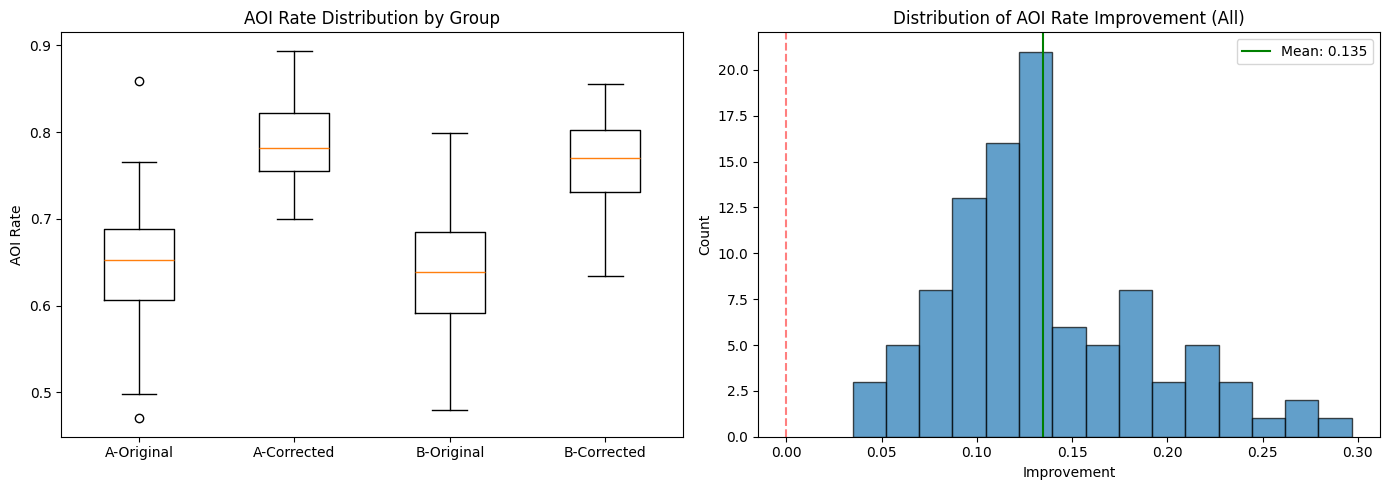


=== Summary Statistics ===
       mean_original_rate  mean_corrected_rate  mean_improvement
group                                                           
A                0.646096             0.792163          0.146068
B                0.637281             0.760916          0.123635


In [24]:
# バッチ結果がある場合の可視化
batch_summary_path = os.path.join(OUTPUT_BASE, 'batch_summary.csv')
if os.path.exists(batch_summary_path):
    batch_results = pd.read_csv(batch_summary_path)
    
    # グループ別の比較
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    for phase in batch_results['phase'].unique():
        phase_data = batch_results[batch_results['phase'] == phase]
        
        # 箱ひげ図: グループ別AOI内率
        group_a = phase_data[phase_data['group'] == 'A']['mean_corrected_rate']
        group_b = phase_data[phase_data['group'] == 'B']['mean_corrected_rate']
        
    axes[0].boxplot([batch_results[batch_results['group'] == 'A']['mean_original_rate'],
                     batch_results[batch_results['group'] == 'A']['mean_corrected_rate'],
                     batch_results[batch_results['group'] == 'B']['mean_original_rate'],
                     batch_results[batch_results['group'] == 'B']['mean_corrected_rate']],
                    labels=['A-Original', 'A-Corrected', 'B-Original', 'B-Corrected'])
    axes[0].set_ylabel('AOI Rate')
    axes[0].set_title('AOI Rate Distribution by Group')
    
    # 改善率のヒストグラム
    axes[1].hist(batch_results['mean_improvement'], bins=15, edgecolor='black', alpha=0.7)
    axes[1].axvline(x=0, color='red', linestyle='--', alpha=0.5)
    axes[1].axvline(x=batch_results['mean_improvement'].mean(), color='green', linestyle='-',
                    label=f'Mean: {batch_results["mean_improvement"].mean():.3f}')
    axes[1].set_xlabel('Improvement')
    axes[1].set_ylabel('Count')
    axes[1].set_title('Distribution of AOI Rate Improvement (All)')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # サマリー統計
    print("\n=== Summary Statistics ===")
    print(batch_results.groupby('group')[['mean_original_rate', 'mean_corrected_rate', 'mean_improvement']].mean())
else:
    print("No batch results found. Run the batch correction first.")